In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
logins_df = pd.read_json('logins.json')
udc_df = pd.read_json('ultimate_data_challenge.json')

## 1 - Exploratory Data Analysis

In [3]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
print(logins_df['login_time'].dtype)

datetime64[ns]


In [5]:
logins_df['date'] = logins_df['login_time'].dt.date
logins_df['time'] = logins_df['login_time'].dt.time
logins_df['login_count'] = 1
logins_df.head()

,login_time,date,time,login_count
0,1970-01-01 20:13:18,1970-01-01,20:13:18,1
1,1970-01-01 20:16:10,1970-01-01,20:16:10,1
2,1970-01-01 20:16:37,1970-01-01,20:16:37,1
3,1970-01-01 20:16:36,1970-01-01,20:16:36,1
4,1970-01-01 20:26:21,1970-01-01,20:26:21,1


In [6]:
grouped_df = logins_df.groupby(pd.Grouper(key='login_time', freq='15Min')).sum()
grouped_df.head()

C:\Users\manth\AppData\Local\Temp\ipykernel_18360\312871924.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = logins_df.groupby(pd.Grouper(key='login_time', freq='15Min')).sum()


,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


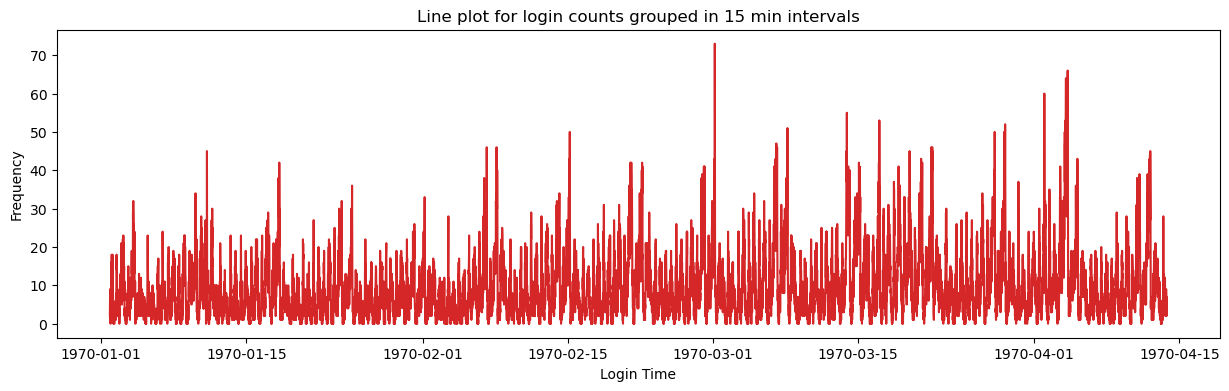

In [7]:
def plot_df(df, x, y, title="", xlabel='Login Time', ylabel='Frequency', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(grouped_df, x=grouped_df.index, y=grouped_df['login_count'], title='Line plot for login counts grouped in 15 min intervals')

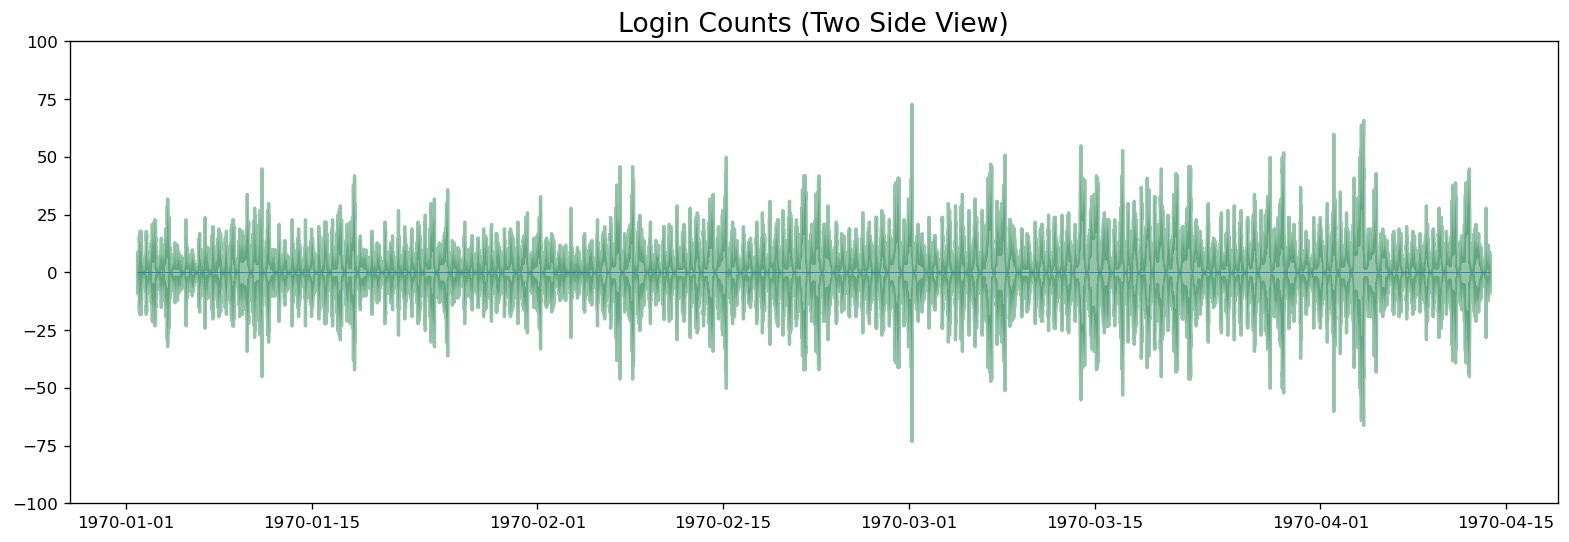

In [8]:
x = grouped_df.index.values
y1 = grouped_df['login_count'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-100, 100)
plt.title('Login Counts (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(grouped_df.index), xmax=np.max(grouped_df.index), linewidth=.5)
plt.show()

The time series follows a general repetitive pattern on scale of every 10 days or so.

## 2 - Experiment and Metrics Design

1. The key measure of success for this experiment is a greater average of driver partners from one city operating in the other city during the peak hours.

2a. I would create two random samples of driver partners, one for each city, and observe their activity with and without the toll to assess whether the proposed changes are effective. 

2b. I would use a 2-tailed t test to verify the significance of the observation. We should use 2-tailed because we are trying to assess a significant change in either direction from the mean number of driver partners from opposite cities. The rationale for a t-test is simply that we don't have access to the population standard devation therefore we have to use the sample standard devation.

2c. The result from 2-tailed t test would be significant if it is less than 0.05, meaning that there is significant evidence to conclude that the proposed change leads to success.

## 3 - Predictive Modeling

In [9]:
udc_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [10]:
udc_df.shape

(50000, 12)

In [11]:
udc_df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [12]:
udc_df['signup_date'] = pd.to_datetime(udc_df['signup_date'])
udc_df['last_trip_date'] = pd.to_datetime(udc_df['last_trip_date'])
udc_df['ultimate_black_user'] = udc_df['ultimate_black_user'].astype(int) 
udc_df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                int32
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [13]:
udc_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [14]:
udc_df.dropna(axis=0,inplace=True)

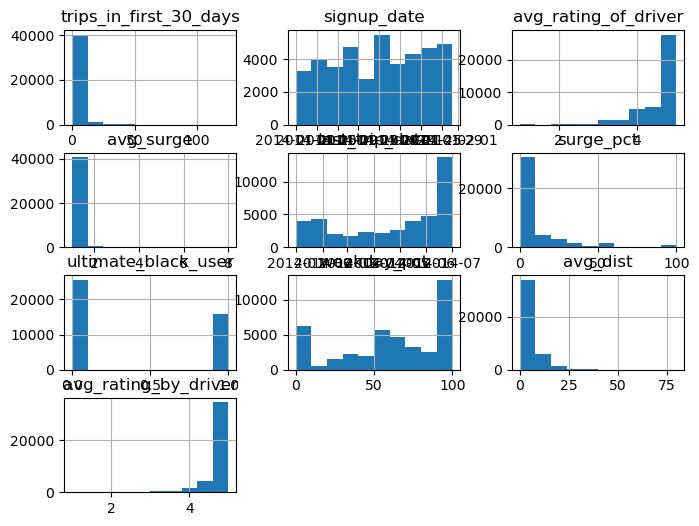

In [15]:
udc_df.hist(figsize = (8,6))
plt.show()

C:\Users\manth\AppData\Local\Temp\ipykernel_18360\2788310950.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(udc_df.corr())


<AxesSubplot:>

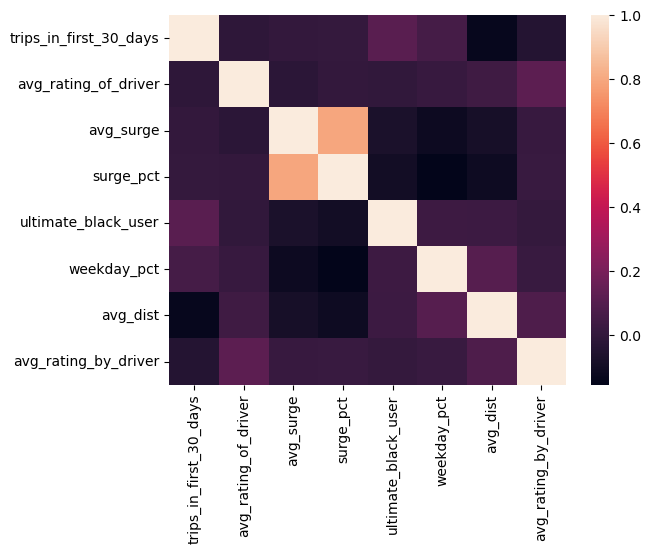

In [16]:
sns.heatmap(udc_df.corr())

In [17]:
udc_df['first_month_retention'] =(udc_df['trips_in_first_30_days'] > 0)
udc_df["first_month_retention"] = udc_df["first_month_retention"].astype(int)
udc_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,first_month_retention
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,1


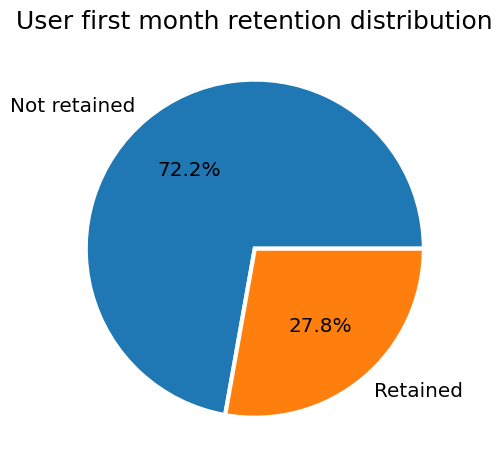

In [18]:
retention_counts = udc_df['first_month_retention'].value_counts()
retention_percentages = pd.Series([(x / udc_df.shape[0]) * 100.00 for x in retention_counts])

fig, ax = plt.subplots()
labels = ['Not retained','Retained']
ax.pie(retention_percentages, labels=labels, autopct='%.1f%%',wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'})
ax.set_title('User first month retention distribution',fontsize=18)
plt.tight_layout()

In [19]:
nb_months = (udc_df['last_trip_date'].dt.month - udc_df['signup_date'].dt.month) + 1
udc_df['six_month_retention'] = (nb_months == 6)
udc_df['six_month_retention'] = udc_df['six_month_retention'].astype(int)
udc_df['city'] = udc_df['city'].map({"King's Landing": 0, 'Astapor': 1, 'Winterfell': 2})
udc_df['phone'] = udc_df['phone'].map({'iPhone': 0, 'Android': 1})
udc_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,first_month_retention,six_month_retention
0,0,4,2014-01-25,4.7,1.10,2014-06-17,0,15.4,1,46.2,3.67,5.0,1,1
1,1,0,2014-01-29,5.0,1.00,2014-05-05,1,0.0,0,50.0,8.26,5.0,0,0
2,1,3,2014-01-06,4.3,1.00,2014-01-07,0,0.0,0,100.0,0.77,5.0,1,0
3,0,9,2014-01-10,4.6,1.14,2014-06-29,0,20.0,1,80.0,2.36,4.9,1,1
4,2,14,2014-01-27,4.4,1.19,2014-03-15,1,11.8,0,82.4,3.13,4.9,1,0


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, ConfusionMatrixDisplay

In [21]:
X = udc_df.drop(['last_trip_date','signup_date','six_month_retention'],axis=1)
y = udc_df['six_month_retention']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=100)

In [22]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [23]:
print('Accuracy:',accuracy_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred, zero_division=1))
print('Precision:',precision_score(y_test, y_pred, zero_division=1))
print('CL Report:',classification_report(y_test, y_pred, zero_division=1))

Accuracy: 0.7399283468596914
Recall: 0.6629743962229889
Precision: 0.6821748878923767
CL Report:               precision    recall  f1-score   support

           0       0.78      0.79      0.78      8170
           1       0.68      0.66      0.67      5507

    accuracy                           0.74     13677
   macro avg       0.73      0.73      0.73     13677
weighted avg       0.74      0.74      0.74     13677



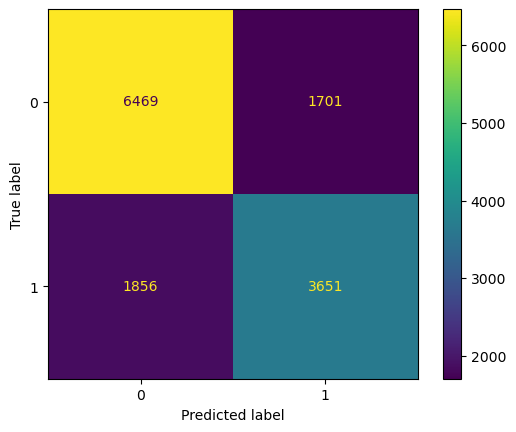

In [24]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

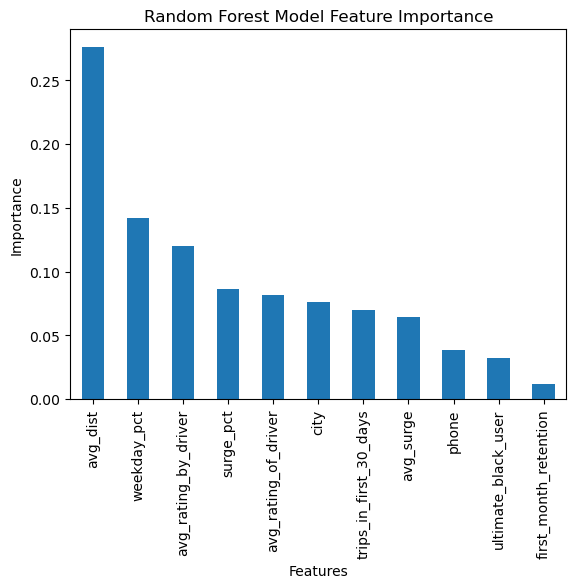

In [25]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Model Feature Importance')
plt.show()

I chose to use random forest model for predicting user retention in the sixth month because it has reduced overfitting, greater accuracy and its easy to scale and interpret. The model performance is adequate, registering a ~74% accuracy in predicting retention for the test dataset. The three most important features according to the RF model in the dataset are avg_dist, weekday_pct, avg_rating_by_driver. An alternative model that can be considered to improve performance would be XGBoost.

Ultimate can still utilize the insights gained from this model. Namely, that avg_dist traveled by the users and the frequency of use during the weekdays are highly correlated with their retention. Furthermore, users that are retained in the first 30 days are not necessarily likely to be retained in the sixth month, as there is little correlation between those two variables.